In [2]:
import wrds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from arch import arch_model

# Connect to WRDS
db = wrds.Connection(wrds_username='simengut')

Loading library list...
Done


In [3]:
renewwable_tickers = ['ICLN', 'PBW', 'QCLN']
nonrenewable_tickers = ['XLE']
benchmark = ["SPY"]

# SQL query to fetch the data
sql_query = """
SELECT 
    a.permno,
    a.date,
    b.ticker,
    b.comnam,
    b.cusip,
    a.prc,
    a.vol,
    a.ret
FROM 
    crsp.dsf AS a
JOIN 
    crsp.dsenames AS b
ON 
    a.permno = b.permno
WHERE 
    b.ticker IN ('ICLN', 'PBW', 'QCLN', 'XLE', 'SPY')
    AND a.date BETWEEN '2007-01-01' AND '2024-12-31'
    AND a.date >= b.namedt
    AND a.date <= b.nameendt
ORDER BY 
    b.ticker,
    a.date;
"""

# Execute query and get results
df = db.raw_sql(sql_query)

# Display the first few rows
df.head()

,permno,date,ticker,comnam,cusip,prc,vol,ret
0,92720,2008-06-25,ICLN,ISHARES TRUST,46428822,52.77,1935.0,<NA>
1,92720,2008-06-26,ICLN,ISHARES TRUST,46428822,51.06,8722.0,-0.032405
2,92720,2008-06-27,ICLN,ISHARES TRUST,46428822,50.157,7588.0,-0.017685
3,92720,2008-06-30,ICLN,ISHARES TRUST,46428822,50.25,16765.0,0.001854
4,92720,2008-07-01,ICLN,ISHARES TRUST,46428822,48.797,14393.0,-0.028915


In [4]:
# Pivot the DataFrame
returns_df = df.pivot(index='date', columns='ticker', values='ret')

# Sort the index (dates)
returns_df = returns_df.sort_index()

# Display the first few rows
print("Returns DataFrame (dates as index, tickers as columns):")
returns_df.head()

Returns DataFrame (dates as index, tickers as columns):


ticker,ICLN,PBW,QCLN,SPY,XLE
date,,,,,
2007-01-03,<NA>,-0.005774,<NA>,-0.001765,-0.034965
2007-01-04,<NA>,0.009292,<NA>,0.002122,-0.018204
2007-01-05,<NA>,-0.023015,<NA>,-0.007976,0.006661
2007-01-08,<NA>,0.006478,<NA>,0.004625,0.0
2007-01-09,<NA>,-0.005266,<NA>,-0.00085,-0.008584


In [14]:
print(returns_df["ICLN"][returns_df["ICLN"].notna()].head(1))
print(returns_df["PBW"][returns_df["PBW"].notna()].head(1))
print(returns_df["QCLN"][returns_df["QCLN"].notna()].head(1))

date
2008-06-26   -0.032405
Name: ICLN, dtype: Float64
date
2007-01-03   -0.005774
Name: PBW, dtype: Float64
date
2007-02-15    0.0
Name: QCLN, dtype: Float64


In [1]:
returns_df

NameError: name 'returns_df' is not defined

In [4]:
# Find the latest start date among all ETFs
latest_start_date = df.groupby('ticker')['date'].min().max()
print(f"Latest start date among all ETFs: {latest_start_date}")

# Filter the data to start from the latest start date
df_filtered = df[df['date'] >= latest_start_date]

# Pivot the filtered data
returns_df = df_filtered.pivot(index='date', columns='ticker', values='ret')

# Sort the index (dates)
returns_df = returns_df.sort_index()

# Display the first few rows
print("\nReturns DataFrame (starting from latest common date):")
returns_df.head()

Latest start date among all ETFs: 2008-06-25

Returns DataFrame (starting from latest common date):


ticker,ICLN,PBW,QCLN,SPY,XLE
date,,,,,
2008-06-25,<NA>,0.008435,0.004221,0.004726,-0.003774
2008-06-26,-0.032405,-0.047398,-0.037065,-0.02716,-0.007231
2008-06-27,-0.017685,-0.015122,-0.012302,-0.005459,0.008787
2008-06-30,0.001854,-0.031699,-0.006669,0.003529,0.014098
2008-07-01,-0.028915,-0.014322,-0.021599,0.003126,0.004182


In [5]:
# check for null values
returns_df.isnull().sum()
returns_df.dropna(inplace=True)
returns_df.head()
returns_df.isnull().sum()
returns_df.dropna(inplace=True)
returns_df

ticker,ICLN,PBW,QCLN,SPY,XLE
date,,,,,
2008-06-26,-0.032405,-0.047398,-0.037065,-0.02716,-0.007231
2008-06-27,-0.017685,-0.015122,-0.012302,-0.005459,0.008787
2008-06-30,0.001854,-0.031699,-0.006669,0.003529,0.014098
2008-07-01,-0.028915,-0.014322,-0.021599,0.003126,0.004182
2008-07-02,-0.026375,-0.05397,-0.04382,-0.017137,-0.030163
...,...,...,...,...,...
2024-12-24,0.003448,0.026706,0.017939,0.011115,0.008459
2024-12-26,-0.003436,0.026012,-0.001399,0.000067,-0.000827
2024-12-27,-0.006035,-0.016901,-0.015966,-0.010527,-0.000118


In [14]:
returns_df.to_csv('daily_returns_df.csv')

In [6]:
# Create separate DataFrames for renewable and non-renewable ETFs
nonrenewable_df = returns_df[['XLE', 'SPY']].copy()
renewable_df = returns_df.drop('XLE', axis=1).copy()
renewable_df = renewable_df.drop('SPY', axis=1).copy()

# Save both DataFrames to separate CSV files
nonrenewable_df.to_csv('nonrenewable_etf_returns.csv')
renewable_df.to_csv('renewable_etfs_returns.csv')

print("Non-renewable ETF (XLE) data:")
print(nonrenewable_df.head())
print("\nRenewable ETFs data:")
print(renewable_df.head())

Non-renewable ETF (XLE) data:
ticker           XLE       SPY
date                          
2008-06-26 -0.007231  -0.02716
2008-06-27  0.008787 -0.005459
2008-06-30  0.014098  0.003529
2008-07-01  0.004182  0.003126
2008-07-02 -0.030163 -0.017137

Renewable ETFs data:
ticker          ICLN       PBW      QCLN
date                                    
2008-06-26 -0.032405 -0.047398 -0.037065
2008-06-27 -0.017685 -0.015122 -0.012302
2008-06-30  0.001854 -0.031699 -0.006669
2008-07-01 -0.028915 -0.014322 -0.021599
2008-07-02 -0.026375  -0.05397  -0.04382


In [7]:
# write the returns code to a file
nonrenewable_df.to_csv('data/nonrenewable_etfs_returns.csv')
renewable_df.to_csv('data/renewable_etfs_returns.csv')


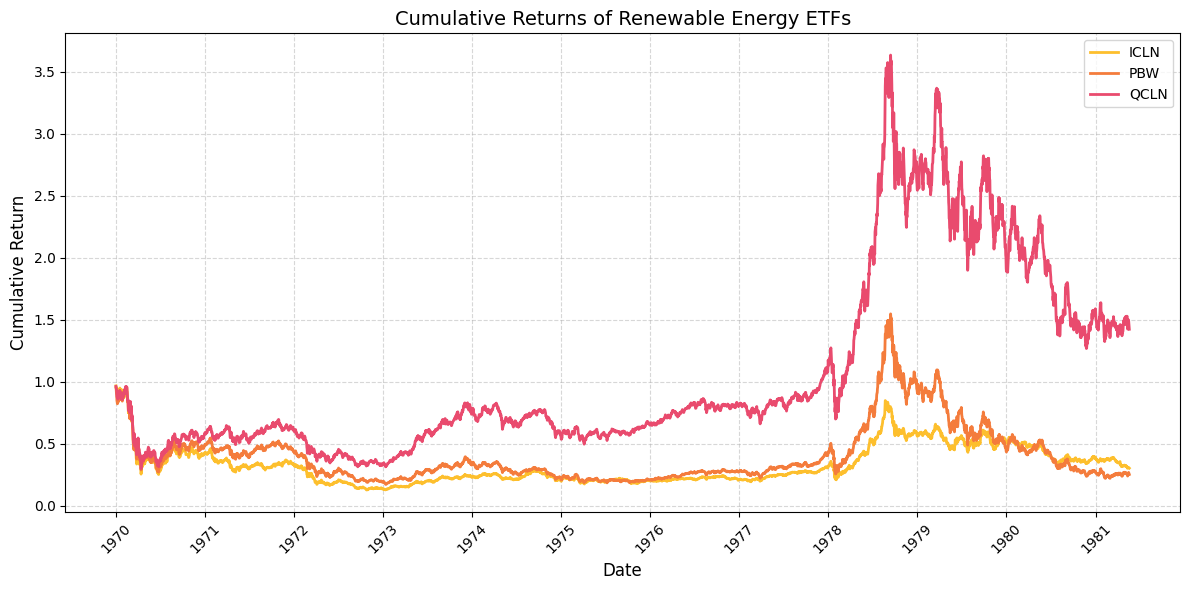

In [8]:
import matplotlib.dates as mdates
 
# Compute cumulative returns
cum_returns_r = (1 + renewable_df).cumprod()
cum_returns_nr = (1 + nonrenewable_df).cumprod()


dates_nr = pd.to_datetime(cum_returns_nr.index)
dates_r = pd.to_datetime(cum_returns_r.index)

# Plot
plt.figure(figsize=(12, 6))

# Set custom colors
colors = {
    "ICLN": "#FDBF2D",  # golden
    "PBW": "#F47C3C",   # orange
    "QCLN": "#E94B6E",  # red-pink
}

for col in cum_returns_r.columns:
    plt.plot(cum_returns_r.index, cum_returns_r[col], label=col, color=colors.get(col, None), linewidth=2)

# Styling
plt.title("Cumulative Returns of Renewable Energy ETFs", fontsize=14)
plt.ylabel("Cumulative Return", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid(True, which='major', linestyle='--', alpha=0.5)

# Set x-ticks to show only every 100th date
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)


plt.legend()
plt.tight_layout()
plt.show()

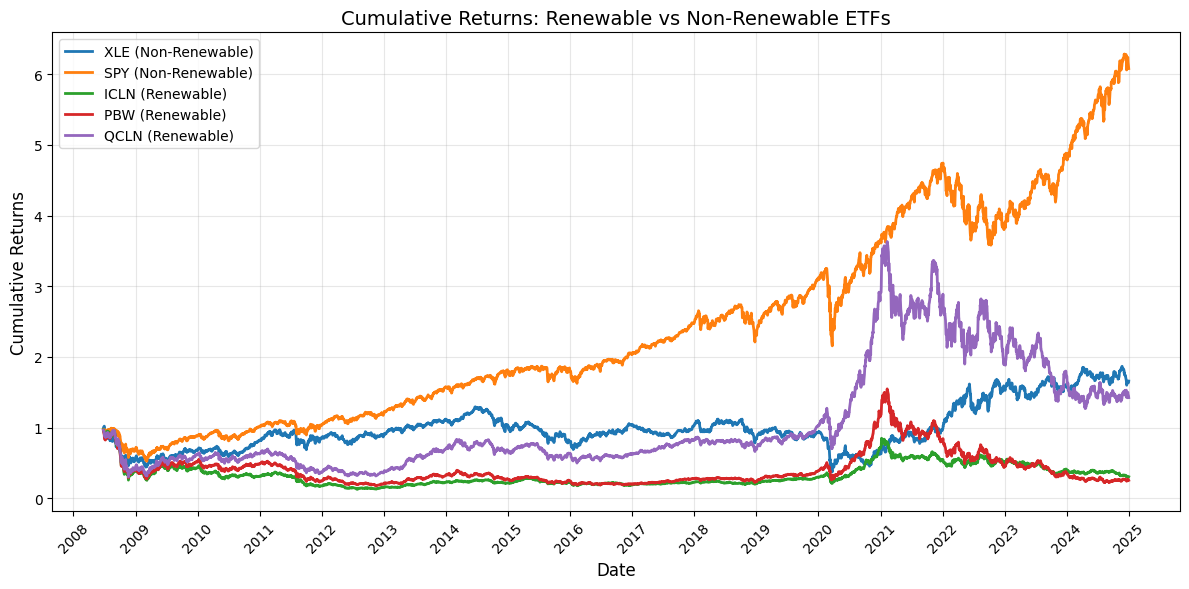

In [9]:
plt.figure(figsize=(12, 6))

# Convert indices to datetime if they're not already
dates_nr = pd.to_datetime(cum_returns_nr.index)
dates_r = pd.to_datetime(cum_returns_r.index)

# Plot both cumulative returns series
plt.plot(dates_nr, cum_returns_nr['XLE'], label='XLE (Non-Renewable)', linewidth=2)
plt.plot(dates_nr, cum_returns_nr['SPY'], label='SPY (Non-Renewable)', linewidth=2)
plt.plot(dates_r, cum_returns_r['ICLN'], label='ICLN (Renewable)', linewidth=2)
plt.plot(dates_r, cum_returns_r['PBW'], label='PBW (Renewable)', linewidth=2)
plt.plot(dates_r, cum_returns_r['QCLN'], label='QCLN (Renewable)', linewidth=2)

# Customize the plot
plt.title('Cumulative Returns: Renewable vs Non-Renewable ETFs', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.grid(True, alpha=0.3)

# Set x-ticks to show only every 100th date
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

# Add legend
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Compute VaR, CVaR and Max Drawdown for ETFs

      VaR (95%)  CVaR (95%)  Max Drawdown
ICLN    -0.0301     -0.0495        0.3275
PBW     -0.0376     -0.0550        0.3162
QCLN    -0.0350     -0.0515        0.3040
     VaR (95%)  CVaR (95%)  Max Drawdown
XLE    -0.0288     -0.0458        0.3662
SPY    -0.0185     -0.0310        0.2546


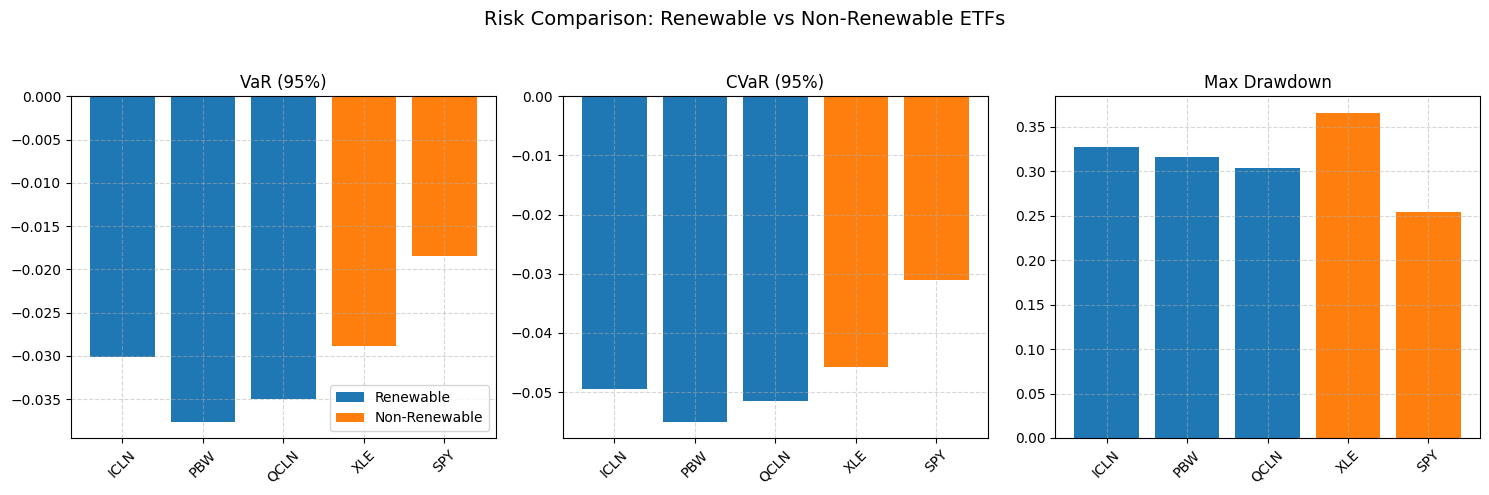

In [10]:
import warnings
warnings.filterwarnings("ignore")

# 1. Compute risk metrics
def compute_risk_metrics(df):
    metrics = {}
    for col in df.columns:
        returns = df[col].dropna()
        var_95 = returns.quantile(0.05)
        cvar_95 = returns[returns <= var_95].mean()
        mdd = (returns.cummax() - returns).max()
        metrics[col] = {
            'VaR (95%)': round(var_95, 4),
            'CVaR (95%)': round(cvar_95, 4),
            'Max Drawdown': round(mdd, 4)
        }
    return pd.DataFrame(metrics).T

# 2. Generate risk metric tables
renewable_risk = compute_risk_metrics(renewable_df)
nonrenewable_risk = compute_risk_metrics(nonrenewable_df)

print(renewable_risk)
print(nonrenewable_risk)

# 3. Combine with group labels
combined_risk = pd.concat(
    [renewable_risk, nonrenewable_risk],
    keys=["Renewable", "Non-Renewable"]
)
combined_risk.index.names = ["Group", "ETF"]

# 4. Melt into tidy format for plotting
melted = combined_risk.reset_index().melt(
    id_vars=["Group", "ETF"],
    var_name="Metric",
    value_name="Value"
)

# 5. Plot
plt.figure(figsize=(15, 5))

metrics = melted["Metric"].unique()
for i, metric in enumerate(metrics):
    ax = plt.subplot(1, 3, i + 1)
    subset = melted[melted["Metric"] == metric]
    
    # Create ordered list of ETFs
    etf_order = ['ICLN', 'PBW', 'QCLN', 'XLE', 'SPY']
    
    # Filter and sort the data according to the ETF order
    subset = subset[subset['ETF'].isin(etf_order)]
    subset['ETF'] = pd.Categorical(subset['ETF'], categories=etf_order, ordered=True)
    subset = subset.sort_values('ETF')
    
    for group in subset["Group"].unique():
        group_data = subset[subset["Group"] == group]
        ax.bar(group_data["ETF"], group_data["Value"], label=group)
    
    ax.set_title(metric)
    ax.set_xticklabels(etf_order, rotation=45)
    ax.grid(True, linestyle="--", alpha=0.5)
    if i == 0:
        ax.legend()

plt.suptitle("Risk Comparison: Renewable vs Non-Renewable ETFs", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# GARCH Volatility testing to get volatility signals 

### make training and test set to later test performance of volatility signals 


In [34]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [11]:
renewable_df

ticker,ICLN,PBW,QCLN
date,,,
2008-06-26,-0.032405,-0.047398,-0.037065
2008-06-27,-0.017685,-0.015122,-0.012302
2008-06-30,0.001854,-0.031699,-0.006669
2008-07-01,-0.028915,-0.014322,-0.021599
2008-07-02,-0.026375,-0.05397,-0.04382
...,...,...,...
2024-12-24,0.003448,0.026706,0.017939
2024-12-26,-0.003436,0.026012,-0.001399
2024-12-27,-0.006035,-0.016901,-0.015966


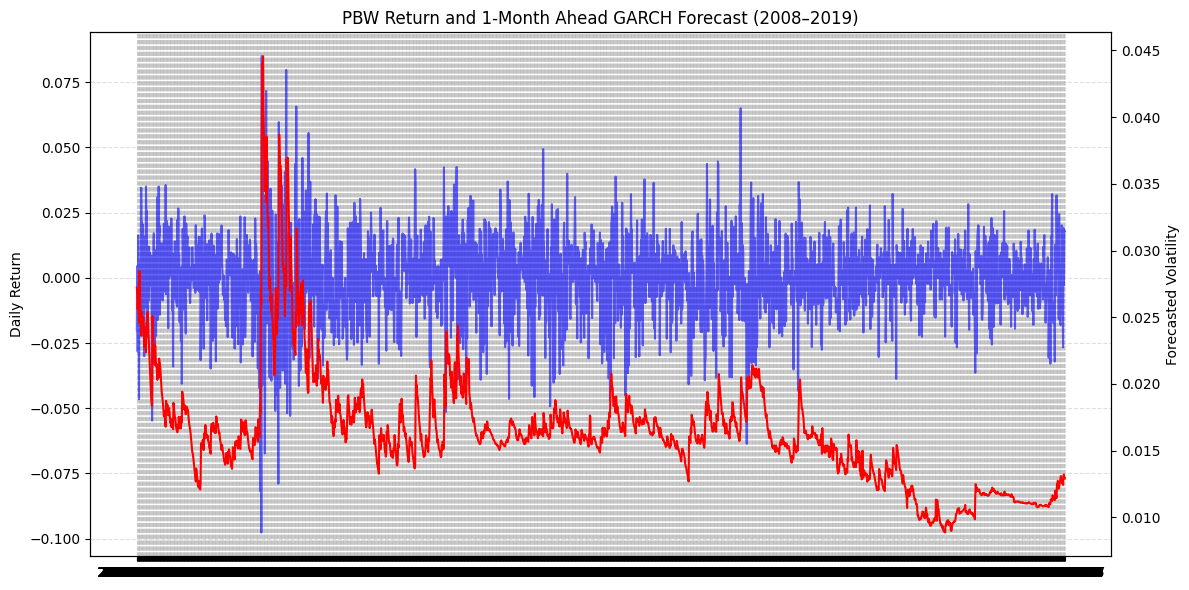

In [12]:
# Step 1: Limit data to 2008–2019 (development phase)
subset_df = renewable_df.loc["2008":"2019"]
ticker = "PBW"
returns = subset_df[ticker].dropna() * 100  # GARCH expects percentage returns

# Step 2: Fit GARCH on full available history up to each point and forecast 1 month ahead
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np

# Define rolling forecast window and forecast horizon
rolling_window = 500  # use 500 days (~2 years) to fit GARCH
forecast_horizon = 22  # forecast 22 trading days (1 month)

# Store results
forecast_vols = []

# Only forecast when we have enough data
for i in range(rolling_window, len(returns) - forecast_horizon):
    window_data = returns.iloc[i - rolling_window:i]
    model = arch_model(window_data, vol='Garch', p=1, q=1)
    try:
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=forecast_horizon)
        # Take average volatility over the 22-day forecast period
        avg_forecast_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
        forecast_vols.append(avg_forecast_vol)
    except:
        forecast_vols.append(np.nan)

# Create time-aligned Series of forecasted volatilities
valid_index = returns.index[rolling_window:-forecast_horizon]
garch_vol_forecast_1M = pd.Series(forecast_vols, index=valid_index, name="1M GARCH Forecast Vol")

# Combine with actual returns
aligned_returns = returns.loc[valid_index] / 100  # convert back to decimal

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(aligned_returns.index, aligned_returns, label=f"{ticker} Return", color="blue", alpha=0.6)
ax2 = ax1.twinx()
ax2.plot(garch_vol_forecast_1M.index, garch_vol_forecast_1M, label="1M Forecasted Vol", color="red")
ax1.set_title(f"{ticker} Return and 1-Month Ahead GARCH Forecast (2008–2019)")
ax1.set_ylabel("Daily Return")
ax2.set_ylabel("Forecasted Volatility")
ax1.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


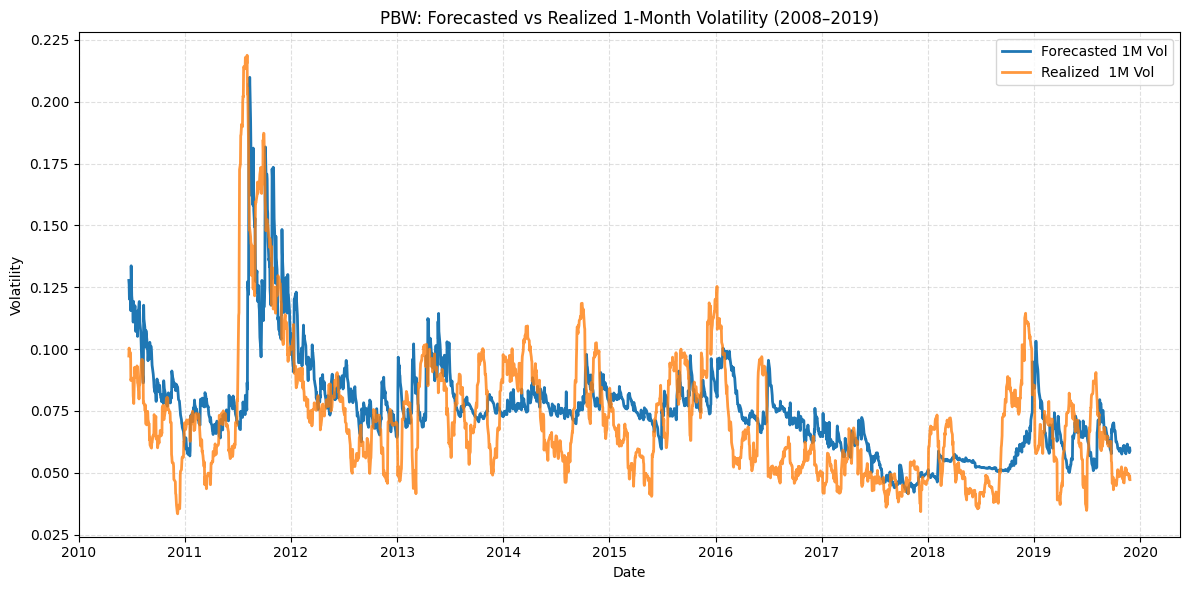

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# — 1) Ensure your index is datetime —
renewable_df.index = pd.to_datetime(renewable_df.index)

# — 2) Subset PBW 2008–2019 and prep returns —
ticker = 'PBW'
subset = renewable_df[ticker].loc['2008':'2019'].dropna()

# — 3) Create percent‐scale returns for GARCH —
returns_pct = subset * 100

rolling_window   = 500
forecast_horizon = 22

forecast_vols = []
forecast_dates = []

# — 4) Rolling GARCH forecasts —
for i in range(rolling_window, len(returns_pct) - forecast_horizon):
    train = returns_pct.iloc[i - rolling_window : i]
    model = arch_model(train, vol='Garch', p=1, q=1)
    res   = model.fit(disp='off')
    fc    = res.forecast(horizon=forecast_horizon, reindex=False)
    
    var_fore = fc.variance.values[-1]        # array of 22 daily var forecasts (pct^2)
    monthly_var_pct2 = var_fore.sum()
    monthly_var_dec  = monthly_var_pct2 / 10000
    forecast_vols.append(np.sqrt(monthly_var_dec))
    forecast_dates.append(returns_pct.index[i])

garch_forecast = pd.Series(forecast_vols, index=forecast_dates, name='Forecasted 1M Vol')

# — 5) Realized volatility by integer slicing —
realized_vols = []
for dt in forecast_dates:
    # find integer position of dt in subset
    pos = subset.index.get_loc(dt)
    # take next 22 returns in decimal form
    window = subset.iloc[pos+1 : pos+1+forecast_horizon]
    # realized variance = sum of squared returns
    realized_var = (window ** 2).sum()
    realized_vols.append(np.sqrt(realized_var))

realized_vol = pd.Series(realized_vols, index=forecast_dates, name='Realized 1M Vol')

# — 6) Plot them —
plt.figure(figsize=(12, 6))
plt.plot(garch_forecast.index, garch_forecast, label='Forecasted 1M Vol', linewidth=2)
plt.plot(realized_vol.index,    realized_vol,    label='Realized  1M Vol', linewidth=2, alpha=0.8)
plt.title(f'{ticker}: Forecasted vs Realized 1‑Month Volatility (2008–2019)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [28]:

def compute_forecast_and_realized_vol(
    returns_df: pd.DataFrame,
    ticker: str,
    start: str,
    end: str,
    rolling_window: int = 500,
    forecast_horizon: int = 22
) -> (pd.Series, pd.Series):
    """
    Compute 1‑month ahead GARCH(1,1) forecasted volatility and realized volatility.

    Parameters:
    - returns_df: DataFrame of decimal returns, index is datetime, columns are tickers
    - ticker: the column name to analyze
    - start, end: date strings like '2008-01-01'
    - rolling_window: number of days for in-sample GARCH fit
    - forecast_horizon: days ahead to forecast & realized window (e.g. 22)

    Returns:
    - forecast_vol: Series of forecasted vol, indexed by forecast date
    - realized_vol: Series of realized vol, same index
    """
    # Ensure datetime index
    df = returns_df.copy()
    df.index = pd.to_datetime(df.index)

    # Subset and drop missing
    series = df[ticker].loc[start:end].dropna()

    # Convert to percent scale for GARCH
    pct_returns = series * 100

    forecast_dates = []
    forecast_vols = []
    # Rolling GARCH forecasts
    for i in range(rolling_window, len(pct_returns) - forecast_horizon):
        window = pct_returns.iloc[i - rolling_window : i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        res = model.fit(disp='off')
        fc = res.forecast(horizon=forecast_horizon, reindex=False)
        # Sum daily variances (pct^2) and convert to decimal var
        var_fore = fc.variance.values[-1]
        monthly_var_dec = var_fore.sum() / 10000
        forecast_vols.append(np.sqrt(monthly_var_dec))
        forecast_dates.append(pct_returns.index[i])

    forecast_vol = pd.Series(forecast_vols, index=forecast_dates, name='Forecasted 1M Vol')

    # Compute realized vol by integer slicing
    realized_vols = []
    for dt in forecast_dates:
        pos = series.index.get_loc(dt)
        window = series.iloc[pos+1 : pos+1+forecast_horizon]
        realized_var = (window ** 2).sum()
        realized_vols.append(np.sqrt(realized_var))

    realized_vol = pd.Series(realized_vols, index=forecast_dates, name='Realized 1M Vol')
    return forecast_vol, realized_vol


In [ ]:
def plot_forecast_vs_realized_vol(
    forecast_vol: pd.Series,
    realized_vol: pd.Series,
    ticker: str,
    start: str,
    end: str):
    """
    Plot forecasted vs realized 1‑month vol.

    Parameters:
    - forecast_vol: Series from compute_forecast_and_realized_vol
    - realized_vol: Series from compute_forecast_and_realized_vol
    - ticker, start, end: metadata for title
    """
    plt.figure(figsize=(12, 6))
    plt.plot(forecast_vol.index, forecast_vol, label='Forecasted 1M Vol', linewidth=2)
    plt.plot(realized_vol.index,    realized_vol,    label='Realized  1M Vol', linewidth=2, alpha=0.8)
    plt.title(f'{ticker}: Forecasted vs Realized 1‑Month Volatility ({start}–{end})')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [31]:
forecast_ICLN, realized_ICLN = compute_forecast_and_realized_vol(renewable_df, 'ICLN', '2008-01-01', '2019-12-31')
forecast_PBW, realized_PBW = compute_forecast_and_realized_vol(renewable_df, 'PBW', '2008-01-01', '2019-12-31')
forecast_QCLN, realized_QCLN = compute_forecast_and_realized_vol(renewable_df, 'QCLN', '2008-01-01', '2019-12-31')

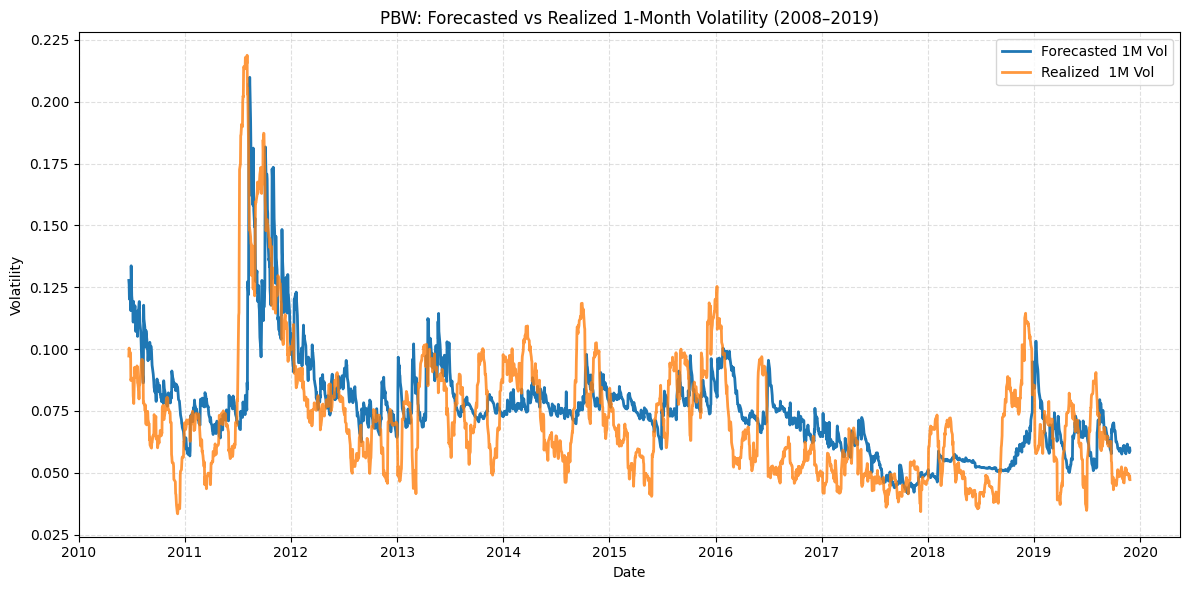

In [30]:
plot_forecast_vs_realized_vol(forecast_PBW, realized_PBW, 'PBW', '2008', '2019')

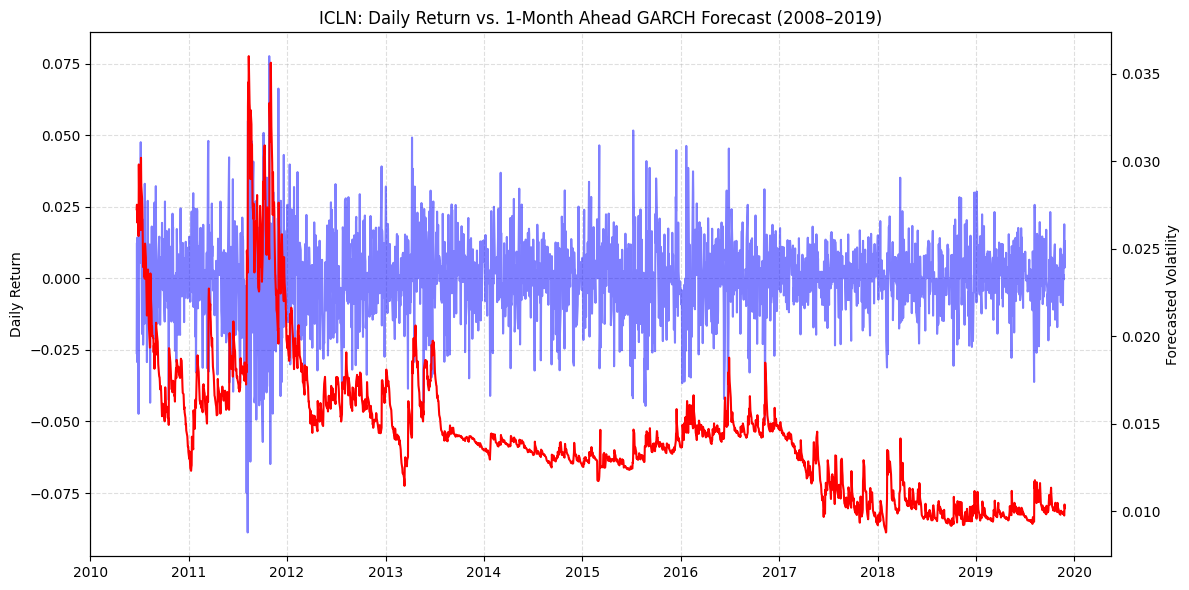

Processing ICLN...
Processing PBW...
Processing QCLN...
✅ Saved hedged returns to 'renewable_hedged_returns.csv'


# GARCH Hedging 

In [15]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Parameters
rolling_window = 500
forecast_horizon = 22
de_risk_pct = 0.5
percentile_threshold = 0.9

# Restrict data to 2008–2019
renewable_df.index = pd.to_datetime(renewable_df.index)
renewable_subset = renewable_df.loc["2008":"2019"]

hedged_returns = {}
hedge_log = {}  # Store decision logs
hedge_trigger_dates_dict = {}  # NEW: stores dates with hedge activation

for col in renewable_subset.columns:
    print(f"Processing {col}...")
    returns = renewable_subset[col].dropna() * 100
    forecast_vols = []
    decisions = []
    hedge_dates = []

    for i in range(rolling_window, len(returns) - forecast_horizon):
        window = returns.iloc[i - rolling_window:i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        try:
            res = model.fit(disp="off")
            forecast = res.forecast(horizon=forecast_horizon)
            avg_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
            forecast_vols.append(avg_vol)
        except:
            forecast_vols.append(np.nan)

    valid_index = returns.index[rolling_window:-forecast_horizon]
    vol_signal = pd.Series(forecast_vols, index=valid_index)
    threshold = vol_signal.quantile(percentile_threshold)

    raw_returns = returns.loc[valid_index] / 100
    hedged = raw_returns.copy()

    for date in valid_index:
        vol = vol_signal.loc[date]
        if vol > threshold:
            decision = f"{date.date()}: De-risked (Vol={vol:.4f} > {threshold:.4f})"
            hedged.loc[date] *= (1 - de_risk_pct)
            hedge_dates.append(date)  # store hedge activation date
        else:
            decision = f"{date.date()}: Full exposure (Vol={vol:.4f} <= {threshold:.4f})"
        decisions.append(decision)

    hedged_returns[col] = hedged
    hedge_log[col] = decisions
    hedge_trigger_dates_dict[col] = hedge_dates  # save hedge dates per ETF

# Save returns
hedged_renewable_df = pd.DataFrame(hedged_returns)
hedged_renewable_df.to_csv("renewable_hedged_returns.csv")

# Save logs
with open("hedge_decision_log.txt", "w") as f:
    for col, logs in hedge_log.items():
        f.write(f"\n=== {col} Hedge Decision Log ===\n")
        for entry in logs:
            f.write(entry + "\n")

# Save hedge trigger dates
with open("hedge_trigger_dates.txt", "w") as f:
    for col, dates in hedge_trigger_dates_dict.items():
        f.write(f"\n=== {col} Hedge Trigger Dates ===\n")
        for d in dates:
            f.write(str(d.date()) + "\n")

print("✅ Saved hedged returns, decision logs, and hedge trigger dates.")


Processing ICLN...
Processing PBW...
Processing QCLN...
✅ Saved hedged returns, decision logs, and hedge trigger dates.


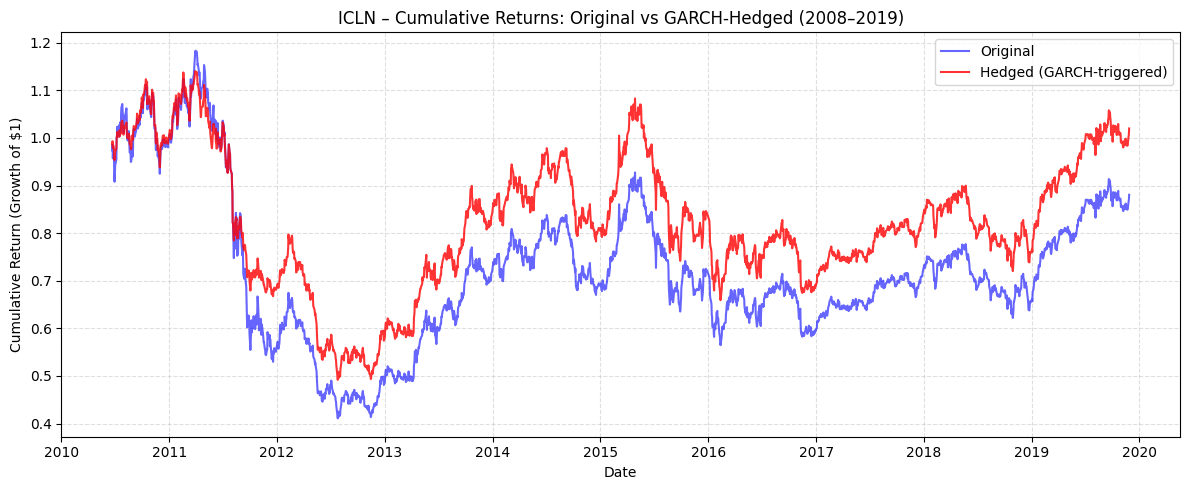

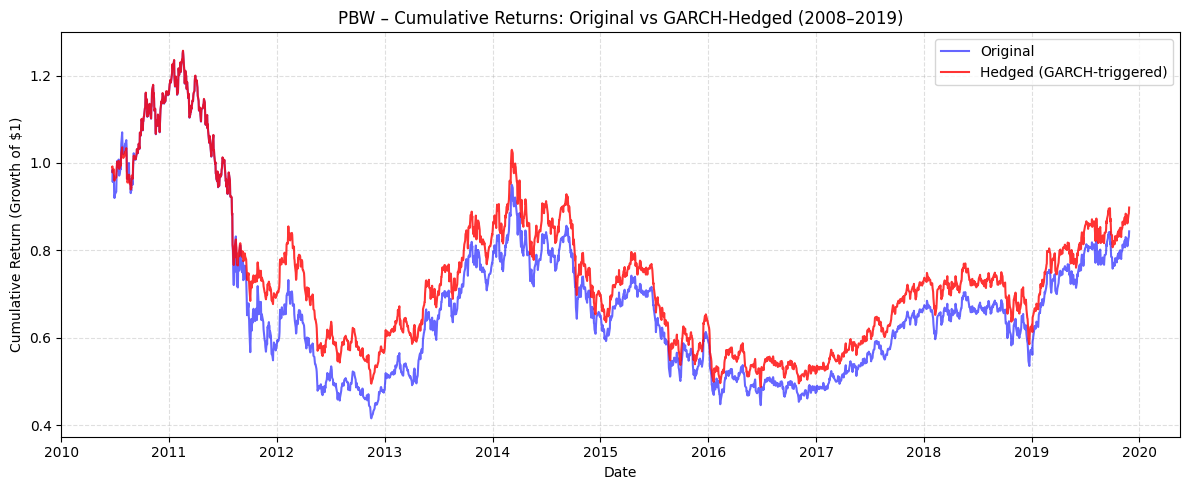

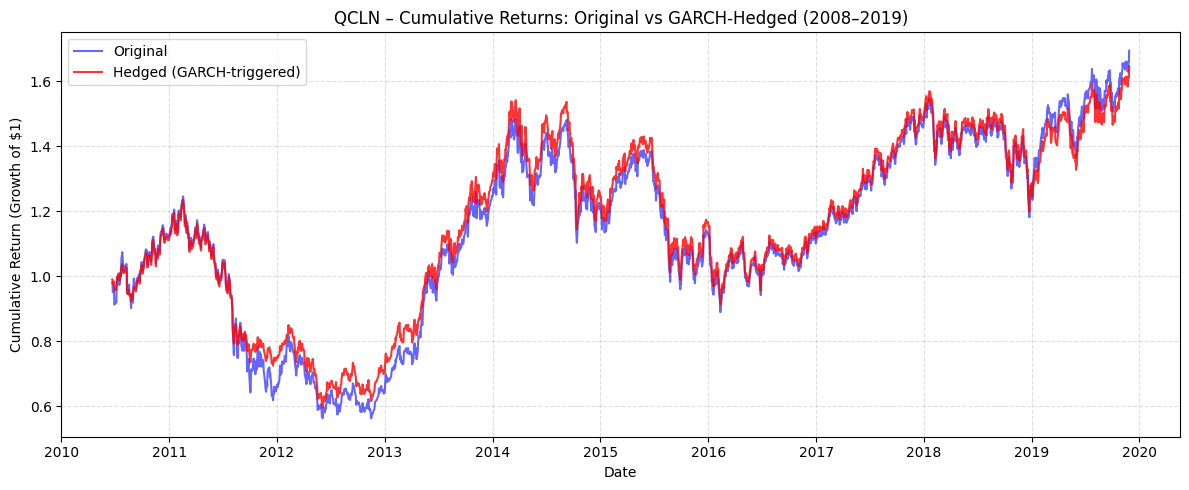

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
renewable_df = pd.read_csv("renewable_etfs_returns.csv", parse_dates=["date"], index_col="date")
hedged_renewable_df = pd.read_csv("renewable_hedged_returns.csv", parse_dates=["date"], index_col="date")

# Align date range
renewable_df = renewable_df.loc[hedged_renewable_df.index]

# Plot cumulative returns for each ETF
for col in hedged_renewable_df.columns:
    cum_orig = (1 + renewable_df[col]).cumprod()
    cum_hedged = (1 + hedged_renewable_df[col]).cumprod()

    plt.figure(figsize=(12, 5))
    plt.plot(cum_orig.index, cum_orig, label="Original", color="blue", alpha=0.6)
    plt.plot(cum_hedged.index, cum_hedged, label="Hedged (GARCH-triggered)", color="red", alpha=0.8)
    plt.title(f"{col} – Cumulative Returns: Original vs GARCH-Hedged (2008–2019)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (Growth of $1)")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [20]:
# Load data
renewable_df = pd.read_csv("renewable_etfs_returns.csv", parse_dates=["date"], index_col="date")
hedged_renewable_df = pd.read_csv("renewable_hedged_returns.csv", parse_dates=["date"], index_col="date")

# Align to same index
renewable_df = renewable_df.loc[hedged_renewable_df.index]

# Define risk metric function
def risk_metrics(df):
    metrics = {}
    for col in df.columns:
        returns = df[col].dropna()
        var = returns.quantile(0.05)
        cvar = returns[returns <= var].mean()
        mdd = (returns.cummax() - returns).max()
        metrics[col] = {
            "VaR (95%)": round(var, 4),
            "CVaR (95%)": round(cvar, 4),
            "Max Drawdown": round(mdd, 4)
        }
    return pd.DataFrame(metrics).T

# Compute for both
original_risk = risk_metrics(renewable_df)
hedged_risk = risk_metrics(hedged_renewable_df)

# Combine into comparison table
comparison = original_risk.join(hedged_risk, lsuffix="_Original", rsuffix="_Hedged")
print("✅ Risk Metric Comparison (Original vs GARCH-Hedged):")
print(comparison)

# Save to CSV (optional)
comparison.to_csv("risk_comparison_renewable_hedged.csv")

✅ Risk Metric Comparison (Original vs GARCH-Hedged):
      VaR (95%)_Original  CVaR (95%)_Original  Max Drawdown_Original  \
ICLN             -0.0244              -0.0344                 0.1425   
PBW              -0.0278              -0.0378                 0.1639   
QCLN             -0.0275              -0.0368                 0.1291   

      VaR (95%)_Hedged  CVaR (95%)_Hedged  Max Drawdown_Hedged  
ICLN           -0.0217            -0.0296               0.1222  
PBW            -0.0255            -0.0337               0.1286  
QCLN           -0.0252            -0.0332               0.1125  


# Hidden Markov Model on Realized Volatiliti 

### 2-state Gaussigan HMM

State 0: mean vol = 0.0161,   std vol = 0.0046
State 1: mean vol = 0.0384,   std vol = 0.0154


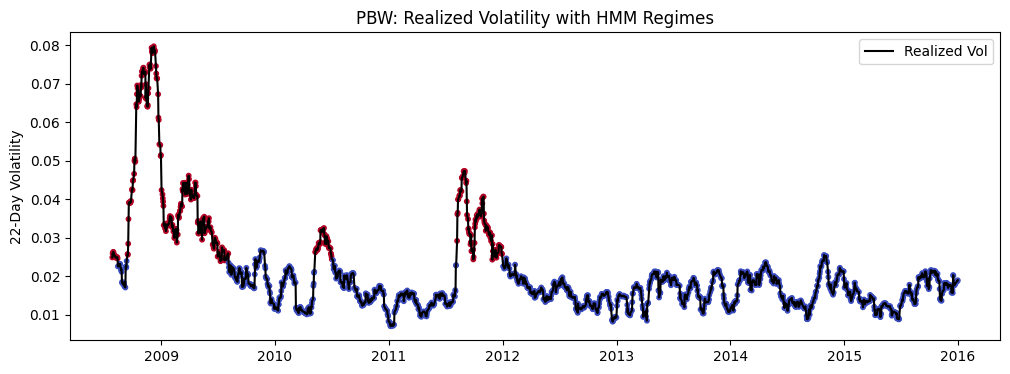

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# 1) Prepare your realized volatility series
#    Use your daily PBW returns (decimal) to compute a 22‑day rolling std
ticker = 'PBW'
ret = renewable_df[ticker].loc['2008':'2015'].dropna()
realized_vol = ret.rolling(window=22).std().dropna()

# 2) Reshape for HMM (n_samples, n_features)
X = realized_vol.values.reshape(-1, 1)

# 3) Fit a 2‑state Gaussian HMM
model = GaussianHMM(n_components=2, covariance_type='full', n_iter=100, random_state=42)
model.fit(X)

# 4) Decode the most likely state sequence
states = model.predict(X)
state_series = pd.Series(states, index=realized_vol.index)

# 5) Inspect the regimes
for i in [0,1]:
    mu = model.means_[i][0]
    sigma = np.sqrt(model.covars_[i][0][0])
    print(f"State {i}: mean vol = {mu:.4f},   std vol = {sigma:.4f}")

# 6) Plot realized vol colored by regime
plt.figure(figsize=(12,4))
plt.plot(realized_vol.index, realized_vol, label='Realized Vol', color='black')
plt.scatter(realized_vol.index, realized_vol, c=states, cmap='coolwarm', s=10)
plt.title(f"{ticker}: Realized Volatility with HMM Regimes")
plt.ylabel("22‑Day Volatility")
plt.legend()
plt.show()

### 3-state Gaussian HMM

Model is not converging.  Current: 7180.690183936186 is not greater than 7183.374746141253. Delta is -2.684562205066868


Regime means & std devs:
 State 0: mean = 0.0385,  std = 0.0162
 State 1: mean = 0.0383,  std = 0.0162
 State 2: mean = 0.0161,  std = 0.0046


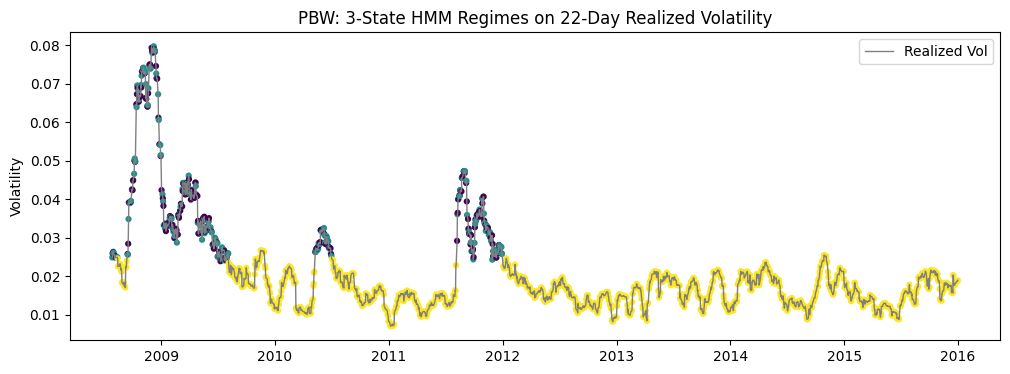

In [37]:
# 1) Compute 22‑day realized volatility for PBW (2008–2019)
ticker = 'PBW'
ret = renewable_df[ticker].loc['2008':'2015'].dropna()
realized_vol = ret.rolling(window=22).std().dropna()

# 2) Reshape for HMM
X = realized_vol.values.reshape(-1, 1)

# 3) Fit a 3‑state Gaussian HMM
model3 = GaussianHMM(
    n_components=3,
    covariance_type='full',
    n_iter=200,
    random_state=42
)
model3.fit(X)

# 4) Decode the most likely state sequence
states3 = model3.predict(X)
state_series3 = pd.Series(states3, index=realized_vol.index)

# 5) Inspect each regime’s volatility characteristics
print("Regime means & std devs:")
for i in range(3):
    mu    = model3.means_[i][0]
    sigma = np.sqrt(model3.covars_[i][0][0])
    print(f" State {i}: mean = {mu:.4f},  std = {sigma:.4f}")

# 6) Plot realized vol colored by regime
plt.figure(figsize=(12,4))
plt.plot(realized_vol.index, realized_vol, color='grey', linewidth=1, label='Realized Vol')
plt.scatter(realized_vol.index, realized_vol, c=states3, cmap='viridis', s=12)
plt.title(f"{ticker}: 3‑State HMM Regimes on 22‑Day Realized Volatility")
plt.ylabel("Volatility")
plt.legend()
plt.show()

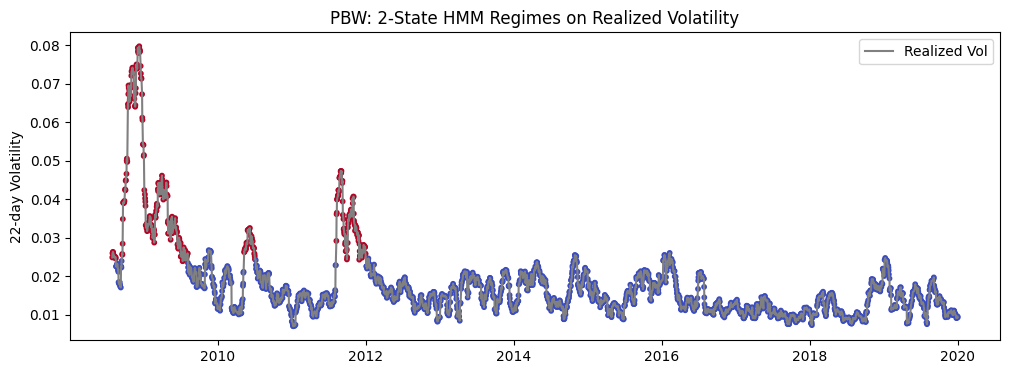

,Original,Hedged
VaR (95%),-0.021407,-0.021407
CVaR (95%),-0.029896,-0.029896
Max Drawdown,0.100232,0.100232


In [ ]:
# Fit both models on your 2008-2015 train set.
# Validate on 2016–2018:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try to import hmmlearn, else instruct user to install
try:
    from hmmlearn.hmm import GaussianHMM
except ImportError as e:
    raise ImportError("hmmlearn not installed. Install via 'pip install hmmlearn' to use HMM functionality.") from e

# Parameters
ticker = 'PBW'
start_train = '2008-01-01'
end_train = '2015-12-31'
end_full = '2019-12-31'
forecast_horizon = 22
de_risk_pct = 0.5  # 50% reduction in exposure in high-vol state

# Ensure datetime index
returns_df = renewable_df.copy()
returns_df.index = pd.to_datetime(returns_df.index)

# 1) Compute 22-day realized volatility series
ret_full = returns_df[ticker].loc['2008':end_full].dropna()
realized_vol_full = ret_full.rolling(window=forecast_horizon).std().dropna()

# 2) Split realized volatility into train and test
rv_train = realized_vol_full.loc[start_train:end_train]
rv_test = realized_vol_full.loc['2016-01-01':end_full]

# 3) Fit 2-state Gaussian HMM on training data
X_train = rv_train.values.reshape(-1, 1)
model_hmm = GaussianHMM(n_components=2, covariance_type='full', n_iter=200, random_state=42)
model_hmm.fit(X_train)

# Identify high-vol state (state with higher mean)
means = model_hmm.means_.flatten()
high_vol_state = np.argmax(means)

# 4) Decode states for full period
X_full = realized_vol_full.values.reshape(-1, 1)
states_full = model_hmm.predict(X_full)
state_series = pd.Series(states_full, index=realized_vol_full.index, name='Regime')

# 5) Plot realized volatility with regimes
plt.figure(figsize=(12,4))
plt.plot(realized_vol_full.index, realized_vol_full, color='grey', label='Realized Vol')
plt.scatter(realized_vol_full.index, realized_vol_full, c=states_full, cmap='coolwarm', s=10)
plt.title(f"{ticker}: 2-State HMM Regimes on Realized Volatility")
plt.ylabel("22-day Volatility")
plt.legend()
plt.show()

# 6) Construct hedged returns: reduce exposure when in high-vol state
raw_returns = ret_full.loc[state_series.index]  # align dates
hedged_returns = raw_returns.copy()
hedged_returns[state_series == high_vol_state] *= (1 - de_risk_pct)

# 7) Evaluate risk metrics on test period
def compute_metrics(returns):
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()
    return var, cvar, mdd

# Align test returns
test_returns = raw_returns.loc[rv_test.index]
test_hedged = hedged_returns.loc[rv_test.index]

metrics_orig = compute_metrics(test_returns)
metrics_hedged = compute_metrics(test_hedged)

# Display metrics
metrics_df = pd.DataFrame({
    'Original': metrics_orig,
    'Hedged': metrics_hedged
}, index=['VaR (95%)','CVaR (95%)','Max Drawdown'])

metrics_df


Model is not converging.  Current: 7180.690183936186 is not greater than 7183.374746141253. Delta is -2.684562205066868


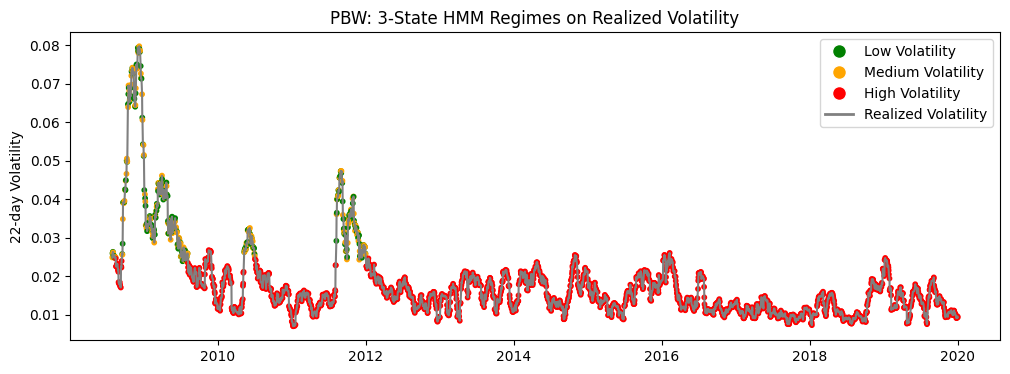

State Means (Low to High Volatility):
Low Volatility State: 0.0161
Medium Volatility State: 0.0383
High Volatility State: 0.0385

Risk Metrics Comparison:


,Original,Hedged
VaR (95%),-0.021407,-0.021407
CVaR (95%),-0.029896,-0.029896
Max Drawdown,0.100232,0.100232


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Try to import hmmlearn, else instruct user to install
try:
    from hmmlearn.hmm import GaussianHMM
except ImportError as e:
    raise ImportError("hmmlearn not installed. Install via 'pip install hmmlearn' to use HMM functionality.") from e

# Parameters
ticker = 'PBW'
start_train = '2008-01-01'
end_train = '2015-12-31'
end_full = '2019-12-31'
forecast_horizon = 22

# De-risking percentages for each state
de_risk_high = 0.50  # 50% reduction in high volatility state
de_risk_medium = 0.25  # 25% reduction in medium volatility state
de_risk_low = 0.00  # 0% reduction in low volatility state

# Ensure datetime index
returns_df = renewable_df.copy()
returns_df.index = pd.to_datetime(returns_df.index)

# 1) Compute 22-day realized volatility series
ret_full = returns_df[ticker].loc['2008':end_full].dropna()
realized_vol_full = ret_full.rolling(window=forecast_horizon).std().dropna()

# 2) Split realized volatility into train and test
rv_train = realized_vol_full.loc[start_train:end_train]
rv_test = realized_vol_full.loc['2016-01-01':end_full]

# 3) Fit 3-state Gaussian HMM on training data
X_train = rv_train.values.reshape(-1, 1)
model_hmm = GaussianHMM(n_components=3, covariance_type='full', n_iter=200, random_state=42)
model_hmm.fit(X_train)

# Identify states by their mean volatility (low to high)
means = model_hmm.means_.flatten()
sorted_states = np.argsort(means)  # States ordered from low to high volatility
low_vol_state = sorted_states[0]
medium_vol_state = sorted_states[1]
high_vol_state = sorted_states[2]

# 4) Decode states for full period
X_full = realized_vol_full.values.reshape(-1, 1)
states_full = model_hmm.predict(X_full)
state_series = pd.Series(states_full, index=realized_vol_full.index, name='Regime')

# 5) Plot realized volatility with regimes
# 5) Plot realized volatility with regimes
plt.figure(figsize=(12,4))
plt.plot(realized_vol_full.index, realized_vol_full, color='grey', label='Realized Vol')

# Create a custom colormap for the three states
colors = ['green', 'orange', 'red']  # Low, Medium, High volatility
state_colors = [colors[state] for state in states_full]

# Plot the scatter points with custom colors
scatter = plt.scatter(realized_vol_full.index, realized_vol_full, 
                     c=state_colors, s=10)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Volatility'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Volatility'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Volatility'),
    Line2D([0], [0], color='grey', lw=2, label='Realized Volatility')
]

plt.title(f"{ticker}: 3-State HMM Regimes on Realized Volatility")
plt.ylabel("22-day Volatility")
plt.legend(handles=legend_elements)
plt.show()

# 6) Construct hedged returns with state-dependent de-risking
raw_returns = ret_full.loc[state_series.index]  # align dates
hedged_returns = raw_returns.copy()

# Apply different de-risking based on state
hedged_returns[state_series == high_vol_state] *= (1 - de_risk_high)
hedged_returns[state_series == medium_vol_state] *= (1 - de_risk_medium)
hedged_returns[state_series == low_vol_state] *= (1 - de_risk_low)

# 7) Evaluate risk metrics on test period
def compute_metrics(returns):
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()
    return var, cvar, mdd

# Align test returns
test_returns = raw_returns.loc[rv_test.index]
test_hedged = hedged_returns.loc[rv_test.index]

metrics_orig = compute_metrics(test_returns)
metrics_hedged = compute_metrics(test_hedged)

# Display metrics
metrics_df = pd.DataFrame({
    'Original': metrics_orig,
    'Hedged': metrics_hedged
}, index=['VaR (95%)','CVaR (95%)','Max Drawdown'])

print("State Means (Low to High Volatility):")
print(f"Low Volatility State: {means[low_vol_state]:.4f}")
print(f"Medium Volatility State: {means[medium_vol_state]:.4f}")
print(f"High Volatility State: {means[high_vol_state]:.4f}")

print("\nRisk Metrics Comparison:")
metrics_df

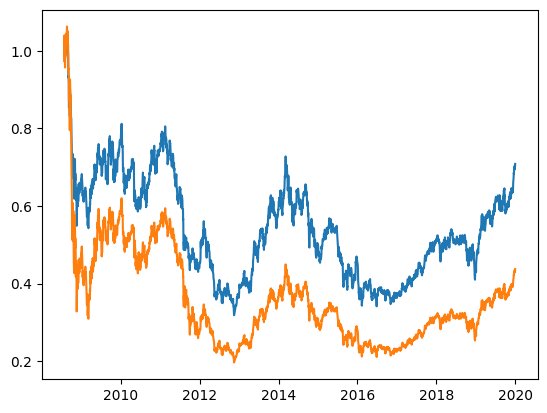

In [52]:
plt.plot((1 + hedged_returns).cumprod())
plt.plot((1 + raw_returns).cumprod())

Model is not converging.  Current: 2664.650859185498 is not greater than 2664.6522742732336. Delta is -0.0014150877354950353
Model is not converging.  Current: 2663.9994175063694 is not greater than 2664.0007101904366. Delta is -0.0012926840672662365
Model is not converging.  Current: 2663.3724187562393 is not greater than 2663.3734703173936. Delta is -0.0010515611543269188
Model is not converging.  Current: 2662.7017264495203 is not greater than 2662.7026225649074. Delta is -0.0008961153871496208
Model is not converging.  Current: 2662.0915151006766 is not greater than 2662.091941352391. Delta is -0.00042625171454346855
Model is not converging.  Current: 2661.518601978697 is not greater than 2661.518744119714. Delta is -0.00014214101702236803
Model is not converging.  Current: 2661.4722656771864 is not greater than 2661.472532349826. Delta is -0.0002666726395545993
Model is not converging.  Current: 2662.0637508840136 is not greater than 2662.0644126845928. Delta is -0.000661800579109

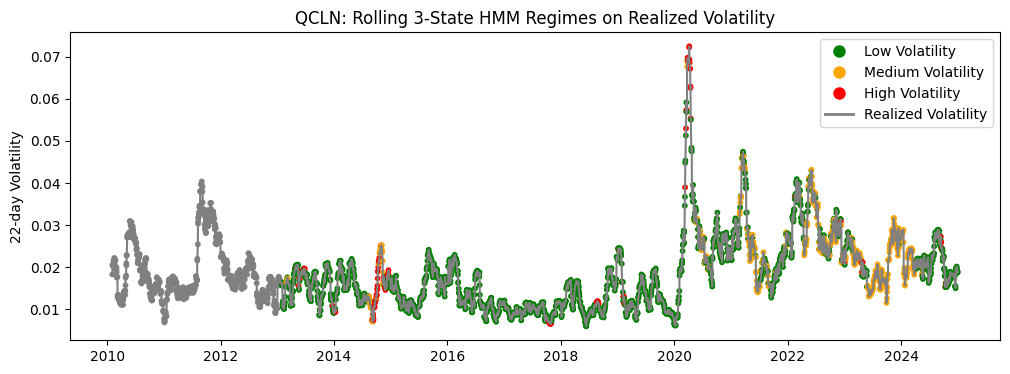

State Means (Low to High Volatility):
Low Volatility State: 0
Medium Volatility State: 2
High Volatility State: 1

Risk Metrics Comparison:


,Original,Hedged
VaR (95%),-0.039508,-0.032500
CVaR (95%),-0.054311,-0.048653
Max Drawdown,0.225466,0.185898


In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

# Parameters
ticker = 'QCLN'
start_train = '2010-01-01'
end_train = '2015-12-31'
start_test = '2019-01-01'
end_full = '2024-12-31'
forecast_horizon = 22

# De-risking percentages for each state
de_risk_high = 0.50  # 50% reduction in high volatility state
de_risk_medium = 0.25  # 25% reduction in medium volatility state
de_risk_low = 0.00  # 0% reduction in low volatility state

# Ensure datetime index
returns_df = renewable_df.copy()
returns_df.index = pd.to_datetime(returns_df.index)

# 1) Compute 22-day realized volatility series
ret_full = returns_df[ticker].loc[start_train:end_full].dropna()
realized_vol_full = ret_full.rolling(window=forecast_horizon).std().dropna()

def rolling_hmm_states(realized_vol, window=1000, n_states=3):
    states = np.full(len(realized_vol), np.nan)
    idx = realized_vol.index
    X = realized_vol.values.reshape(-1,1)
    
    # Clean the data - remove any remaining NaN or inf values
    valid_mask = ~np.isnan(X.flatten()) & ~np.isinf(X.flatten())
    X_clean = X[valid_mask]
    idx_clean = idx[valid_mask]
    
    for t in range(window, len(X_clean)):
        # Get the window of data
        window_data = X_clean[t-window:t]
        
        # Skip if window contains NaN or inf values
        if np.any(np.isnan(window_data)) or np.any(np.isinf(window_data)):
            continue
            
        try:
            model = GaussianHMM(n_components=n_states, 
                              covariance_type='diag',  # Changed to diag for better stability
                              n_iter=100, 
                              tol=1e-2,
                              random_state=0)
            model.fit(window_data)
            states[t] = model.predict(X_clean[t:t+1])[0]
        except:
            continue
    
    return pd.Series(states, index=idx_clean)

# Get rolling HMM states
states_series = rolling_hmm_states(realized_vol_full, window=750, n_states=3)

# Identify states by their mean volatility in the most recent window
def get_state_means(vol_series, states_series, window=750):
    X = vol_series.values.reshape(-1,1)
    valid_mask = ~np.isnan(X.flatten()) & ~np.isinf(X.flatten())
    X_clean = X[valid_mask]
    
    if len(X_clean) < window:
        window = len(X_clean)
    
    model = GaussianHMM(n_components=3, 
                       covariance_type='diag',  # Changed to diag for better stability
                       n_iter=100,
                       tol=1e-2,
                       random_state=0)
    model.fit(X_clean[-window:])
    means = model.means_.flatten()
    sorted_states = np.argsort(means)  # States ordered from low to high volatility
    return sorted_states

# Get state means and identify high/medium/low states
sorted_states = get_state_means(realized_vol_full, states_series)
low_vol_state = sorted_states[0]
medium_vol_state = sorted_states[1]
high_vol_state = sorted_states[2]

# Plot the states
plt.figure(figsize=(12,4))
plt.plot(realized_vol_full.index, realized_vol_full, color='grey', label='Realized Vol')

# Create a custom colormap for the three states
colors = ['green', 'orange', 'red']  # Low, Medium, High volatility
state_colors = [colors[int(state)] if not np.isnan(state) else 'grey' for state in states_series]

# Plot the scatter points with custom colors
scatter = plt.scatter(states_series.index, realized_vol_full.loc[states_series.index], 
                     c=state_colors, s=10)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Volatility'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Medium Volatility'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Volatility'),
    Line2D([0], [0], color='grey', lw=2, label='Realized Volatility')
]

plt.title(f"{ticker}: Rolling 3-State HMM Regimes on Realized Volatility")
plt.ylabel("22-day Volatility")
plt.legend(handles=legend_elements)
plt.show()

# Construct hedged returns with state-dependent de-risking
raw_returns = ret_full.loc[states_series.index]  # align dates
hedged_returns = raw_returns.copy()

# Apply different de-risking based on state
hedged_returns[states_series == high_vol_state] *= (1 - de_risk_high)
hedged_returns[states_series == medium_vol_state] *= (1 - de_risk_medium)
hedged_returns[states_series == low_vol_state] *= (1 - de_risk_low)

# Evaluate risk metrics on test period
def compute_metrics(returns):
    var = returns.quantile(0.05)
    cvar = returns[returns <= var].mean()
    mdd = (returns.cummax() - returns).max()
    return var, cvar, mdd

# Align test returns
test_returns = raw_returns.loc[start_test:end_full]
test_hedged = hedged_returns.loc[start_test:end_full]


metrics_orig = compute_metrics(test_returns)
metrics_hedged = compute_metrics(test_hedged)


# Display metrics
metrics_df = pd.DataFrame({
    'Original': metrics_orig,
    'Hedged': metrics_hedged
}, index=['VaR (95%)','CVaR (95%)','Max Drawdown'])

print("State Means (Low to High Volatility):")
print(f"Low Volatility State: {sorted_states[0]}")
print(f"Medium Volatility State: {sorted_states[1]}")
print(f"High Volatility State: {sorted_states[2]}")

print("\nRisk Metrics Comparison:")
metrics_df

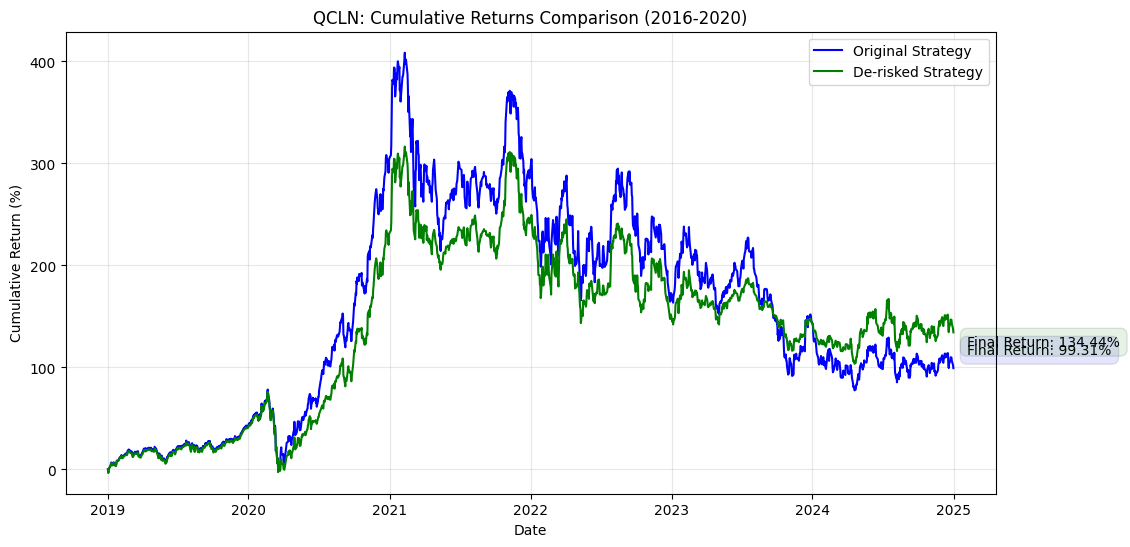


Final Cumulative Returns:
Original Strategy: 99.31%
De-risked Strategy: 134.44%


In [100]:
percent_changes = ((metrics_df["Original"] - metrics_df["Hedged"]) / metrics_df["Original"] * 100).round(2)
percent_changes

# Calculate cumulative returns
cumulative_returns = (1 + test_returns).cumprod() - 1
cumulative_hedged = (1 + test_hedged).cumprod() - 1

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns.index, cumulative_returns * 100, label='Original Strategy', color='blue')
plt.plot(cumulative_hedged.index, cumulative_hedged * 100, label='De-risked Strategy', color='green')

plt.title(f"{ticker}: Cumulative Returns Comparison (2016-2020)")
plt.ylabel("Cumulative Return (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)

# Add final values as text annotations
final_orig = cumulative_returns.iloc[-1] * 100
final_hedged = cumulative_hedged.iloc[-1] * 100

plt.annotate(f'Final Return: {final_orig:.2f}%', 
            xy=(cumulative_returns.index[-1], final_orig),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='blue', alpha=0.1))

plt.annotate(f'Final Return: {final_hedged:.2f}%', 
            xy=(cumulative_hedged.index[-1], final_hedged),
            xytext=(10, -10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.1))

plt.show()

# Print final returns
print("\nFinal Cumulative Returns:")
print(f"Original Strategy: {final_orig:.2f}%")
print(f"De-risked Strategy: {final_hedged:.2f}%")

In [101]:
metrics_df["Percent Improvement"]  = ((metrics_df["Original"] - metrics_df["Hedged"]) / metrics_df["Original"] * 100).round(2)
metrics_df

,Original,Hedged,Percent Improvement
VaR (95%),-0.039508,-0.032500,17.74
CVaR (95%),-0.054311,-0.048653,10.42
Max Drawdown,0.225466,0.185898,17.55


In [83]:
# Calculate percent changes
metrics_comparison_percent = ((metrics_df["Original"] - metrics_df["Hedged"]) / metrics_df["Original"] * 100).round(2)

print("Risk Metrics Comparison with Percent Changes:")
metrics_comparison_percent

Risk Metrics Comparison with Percent Changes:


VaR (95%)       12.68
CVaR (95%)      11.48
Max Drawdown     0.00
dtype: float64

# GARCH signal Options Hedging

In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# Parameters
rolling_window = 500
forecast_horizon = 22
de_risk_pct = 0.5
percentile_threshold = 0.9

# Restrict data to 2008–2019
renewable_df.index = pd.to_datetime(renewable_df.index)
renewable_subset = renewable_df.loc["2008":"2019"]

hedged_returns = {}
hedge_log = {}  # Store decision logs
hedge_trigger_dates_dict = {}  # NEW: stores dates with hedge activation

for col in renewable_subset.columns:
    print(f"Processing {col}...")
    returns = renewable_subset[col].dropna() * 100
    forecast_vols = []
    decisions = []
    hedge_dates = []

    for i in range(rolling_window, len(returns) - forecast_horizon):
        window = returns.iloc[i - rolling_window:i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        try:
            res = model.fit(disp="off")
            forecast = res.forecast(horizon=forecast_horizon)
            avg_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
            forecast_vols.append(avg_vol)
        except:
            forecast_vols.append(np.nan)

    valid_index = returns.index[rolling_window:-forecast_horizon]
    vol_signal = pd.Series(forecast_vols, index=valid_index)
    threshold = vol_signal.quantile(percentile_threshold)

    raw_returns = returns.loc[valid_index] / 100
    hedged = raw_returns.copy()

    for date in valid_index:
        vol = vol_signal.loc[date]
        if vol > threshold:
            decision = f"{date.date()}: De-risked (Vol={vol:.4f} > {threshold:.4f})"
            hedged.loc[date] *= (1 - de_risk_pct)
            hedge_dates.append(date)  # store hedge activation date
        else:
            decision = f"{date.date()}: Full exposure (Vol={vol:.4f} <= {threshold:.4f})"
        decisions.append(decision)

    hedged_returns[col] = hedged
    hedge_log[col] = decisions


In [ ]:
one_month_sql = """
SELECT  o.date,
        o.exdate,
        o.cp_flag,
        o.strike_price/1000.0  AS strike,
        o.best_bid   AS bid,
        o.best_offer AS ask,
        o.volume
FROM    optionm.opprcd2010   o
JOIN    optionm.secnmd       s  USING (secid)
WHERE   s.ticker = 'PBW'
  AND   o.date     BETWEEN '2010-01-01' AND '2010-12-01'
  AND   (o.exdate - o.date) BETWEEN 10 AND 100
  LIMIT 1000;
"""

df = conn.raw_sql(one_month_sql, date_cols=["date", "exdate"])
print(df.head(), f"\n{len(df)} rows returned")

In [33]:
hedge_trigger_dates = pd.read_csv("hedge_trigger_dates.txt", index_col="date", parse_dates=True)
hedge_trigger_dates

ValueError: 'date' is not in list

In [34]:
def get_best_put_option(conn, date, symbol="PBW", secid=13541):
    year = date.year
    try:
        sql = f"""
        SELECT o.date, o.exdate, o.strike_price/1000.0 AS strike,
               o.best_bid, o.best_offer, o.cp_flag
        FROM optionm.opprcd{year} o
        JOIN optionm.secnmd s USING (secid)
        WHERE s.ticker = '{symbol}'
          AND o.cp_flag = 'P'
          AND o.date = '{date.strftime('%Y-%m-%d')}'
          AND (o.exdate - o.date) BETWEEN 25 AND 35
          AND o.best_bid IS NOT NULL AND o.best_offer IS NOT NULL
        """
        options_df = conn.raw_sql(sql, date_cols=["date", "exdate"])
        if options_df.empty:
            return None

        # Load ETF price series (e.g., cumulative PBW price path)
        S0 = (1 + renewable_df[symbol]).cumprod().loc[date]
        options_df["mid"] = (options_df["best_bid"] + options_df["best_offer"]) / 2
        options_df["moneyness"] = options_df["strike"] / S0

        candidates = options_df[(options_df["moneyness"] >= 0.95) & (options_df["moneyness"] <= 1.00)]
        if candidates.empty:
            return None

        best = candidates.iloc[(candidates["moneyness"] - 0.975).abs().argsort()].iloc[0]
        return {
            "cost": best["mid"] / S0,
            "strike": best["strike"],
            "expiry": best["exdate"],
            "spot": S0
        }
    except Exception as e:
        print(f"Option lookup failed for {date.date()}: {e}")
        return None


In [35]:
conn = wrds.Connection(wrds_username='simengut')

# Parameters
rolling_window = 500
forecast_horizon = 22
percentile_threshold = 0.9

# Restrict data to 2008–2019
renewable_df.index = pd.to_datetime(renewable_df.index)
renewable_subset = renewable_df.loc["2008":"2019"]

hedged_returns = {}
hedge_log = {}  # Store decision logs

for col in renewable_subset.columns:
    print(f"Processing {col}...")
    returns = renewable_subset[col].dropna() * 100
    forecast_vols = []
    decisions = []
    hedge_dates = []

    for i in range(rolling_window, len(returns) - forecast_horizon):
        window = returns.iloc[i - rolling_window:i]
        model = arch_model(window, vol='Garch', p=1, q=1)
        try:
            res = model.fit(disp="off")
            forecast = res.forecast(horizon=forecast_horizon)
            avg_vol = np.mean(np.sqrt(forecast.variance.values[-1]) / 100)
            forecast_vols.append(avg_vol)
        except:
            forecast_vols.append(np.nan)

    valid_index = returns.index[rolling_window:-forecast_horizon]
    vol_signal = pd.Series(forecast_vols, index=valid_index)
    threshold = vol_signal.quantile(percentile_threshold)

    raw_returns = returns.loc[valid_index] / 100
    hedged = raw_returns.copy()

    for date in valid_index:
        vol = vol_signal.loc[date]

        if vol > threshold:
            decision = f"{date.date()}: Hedged (Vol={vol:.4f} > {threshold:.4f})"
            
            option = get_best_put_option(conn, date, symbol=col)
            if option:
                cost = option["cost"]
                hedged.loc[date] -= cost

                expiry = option["expiry"]
                strike = option["strike"]
                spot = option["spot"]

                # Save expiry payoff for later (optional: store for final post-loop adjustment)
                if expiry in renewable_df.index:
                    ST = (1 + renewable_df[col]).cumprod().loc[expiry]
                    payoff = max(0, strike - ST) / spot
                    hedged.loc[expiry] += payoff

            hedge_dates.append(date)



            hedge_dates.append(date)  # store hedge activation da
        else:
            decision = f"{date.date()}: Full exposure (Vol={vol:.4f} <= {threshold:.4f})"
        decisions.append(decision)

    hedged_returns[col] = hedged
    hedge_log[col] = decisions
    hedge_trigger_dates_dict[col] = hedge_dates  # save hedge dates per ETF

# Save returns
hedged_renewable_df = pd.DataFrame(hedged_returns)
hedged_renewable_df.to_csv("renewable_hedged_returns.csv")


Loading library list...
Done
Processing ICLN...


KeyboardInterrupt: 

In [ ]:
make date format
start_time = pd.to_datetime('2010-01-01')